# 1.1 Radial velocity analysis of WASP-12b 

### Universidad de La Laguna Exo & Exo 2022 exercise 1

Author: [Hannu Parviainen](mailto:hannu@iac.es)<br>
Last updated: 1.5.2022

This first exercise teaches you how to estimate the minimum planetary mass from radial velocity measurements using [Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference).


## (The absolute basics of) radial velocities

A planet orbiting a star causes the star to [move around the star-planet barycentre](https://exoplanets.nasa.gov/alien-worlds/ways-to-find-a-planet/#/1). This leads to a periodic change in the star's position and velocity,
and the radial component of the star's velocity can be measured using [doppler spectroscopy](https://en.wikipedia.org/wiki/Doppler_spectroscopy). Radial velocity (RV) measurements are used to search for unknown planets and to estimate the minimum masses and orbital periods of known planets.

![Doppler shift vs time](Doppler_Shift_vs_Time.svg "Doppler shift vs time")


A planet with a mass $M_\mathrm{p}$ orbiting a star with a mass $M_\star$ with an orbital period $P$ leads to a periodic signal with a semi-amplitude of

$$
K = \left(\frac{2\pi G}{P}\right)^{1/3} \frac{M_\mathrm{p} \sin i}{(M_\star + M_\mathrm{p})^{2/3}} \frac{1}{(1-e^2)^{1/2}},
$$

where $G$ is the [gravitational constant](https://en.wikipedia.org/wiki/Gravitational_constant), $e$ is the [orbital eccentricity](https://en.wikipedia.org/wiki/Orbital_eccentricity), and $i$ is the [orbital inclination](https://en.wikipedia.org/wiki/Orbital_inclination). After we estimate $P$, $K$, and $M_\star$ we can solve for the minimum planetary mass $M_\mathrm{p} \sin i$. The orbital period and RV semi-amplitude can be estimated directly from the RV signal, but the stellar mass needs to be estimated using other means.


## (The absolute basics of) Bayesian parameter estimation

Measuring the RV semi-amplitude and the orbital period from RV measurements is a *parameter estimation* problem: we assume we have an adequate model to describe the observations, and we want to infer the model parameters with their uncertainties.

We take a [*Bayesian*](http://en.wikipedia.org/wiki/Bayesian_probability) approach to the parameter estimation, where we want to estimate the [*posterior probability*](http://en.wikipedia.org/wiki/Posterior_probability) for the model parameters given their [*prior probabilities*](http://en.wikipedia.org/wiki/Prior_probability) and a set of observations. The posterior probability density given a parameter vector $\theta$ and observational data $D$ is described by the [*Bayes' theorem*](http://en.wikipedia.org/wiki/Bayes%27_theorem) as

$$
P(\theta|D) = \frac{P(\theta) P(D|\theta)}{P(D)}, \qquad P(D|\theta) = \prod P(D_i|\theta),
$$

where $P(\theta)$ is the prior, $P(D|\theta)$ is the [*likelihood*](http://en.wikipedia.org/wiki/Likelihood_function) for the data, and $P(D)$ is a [*normalising factor*](http://en.wikipedia.org/wiki/Marginal_likelihood) we don't need to bother with during MCMC-based parameter estimation. 

The likelihood is a product of individual observation probabilities, and has the unfortunate tendency to end up being either very small or very big. This causes computational headaches, and it is better to work with log probabilities instead, so that

$$
\log P(\theta|D) = \log P(\theta) + \log P(D|\theta),  \qquad \log P(D|\theta) = \sum \log P(D_i|\theta)
$$

where we have omitted the $P(D)$ term from the posterior density.

Now we still need to decide our likelihood density. If we can assume normally distributed white noise--that is, the errors in the observations are independent and identically distributed--we end up with a log likelihood function

$$
 \log P(D|\theta) = -N\log(\sigma) -\frac{N\log 2\pi}{2} - \sum_{i=0}^N \frac{(o_i-m_i)^2}{2\sigma^2},
$$

where $N$ is the number of datapoints, $\sigma$ is the white noise standard deviation, $o$ is the observed data, and $m$ is the model. 

This should be enough for these exercies, but you can find more information from [A primer about Bayesian statistics](https://ui.adsabs.harvard.edu/link_gateway/2018haex.bookE.149P/EPRINT_PDF) and the references therein.

## Initialisation

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import astropy.units as u

from matplotlib.pyplot import subplots, setp, rc, Rectangle
from numpy import argmax, median
from astropy.table import Table
from astropy.timeseries import LombScargle
from corner import corner

from pytransit.lpf.rvlpf import RVLPF

rc('figure', figsize=(13,4))

## 1.1 Read in the RV data 

The radial velocity measurements consist of mid-observation times, radial velocity values, and radial velocity measurement uncertainties (also called as 'errors'). We use the data from [Yee et al. (2019)](https://iopscience.iop.org/article/10.3847/2041-8213/ab5c16). The data is stored as a CDS table that can be read directly using `astropy.table.Table`.

In [4]:
rv_data = Table.read('data/wasp_12b_yee_2019.dat', format='ascii.cds')

It's important to understand what sort of data we're dealing with, so we begin by displaying the table header and the five first rows.

In [5]:
rv_data[:5]  

BJD,RVel,e_RVel
d,m / s,m / s
float64,float64,float64
2455521.959432,-136.635,2.534
2455543.089922,5.728,2.919
2455545.983884,-162.39,2.822
2455559.906718,141.616,2.345
2455559.917563,115.818,2.727


It's also useful to visualise directly what we're working with, so we next plot the radial velocity data and its uncertainties as a function of time.

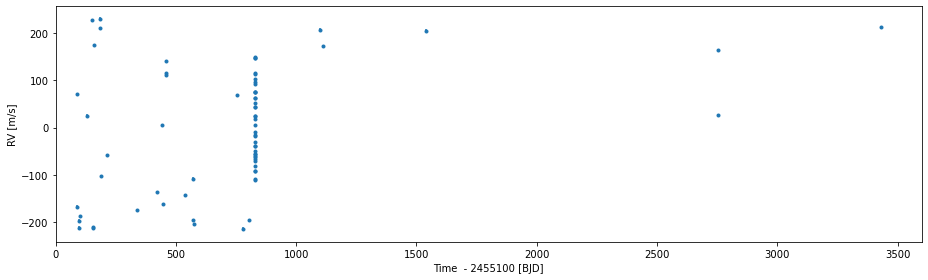

In [6]:
fig, ax = subplots()
ax.errorbar(rv_data['BJD'] - 2455100, rv_data['RVel'], rv_data['e_RVel'], fmt='.')
setp(ax, xlabel='Time  - 2455100 [BJD]', ylabel='RV [m/s]', xlim=(0, 3600))
fig.tight_layout()

### <span style="color:darkblue">Questions and exercises:</span>

1. Try to describe the logic behind the time sampling of the RV observations.

    For the first two years the sampling is relatively sparse and at seemingly random times. This could be a search phase for candidate signals (although the planet was discovered with transit detection in 2008, about two years before the first point in the graph). The irregular timing of the observations avoids observing by chance at a multiple of the planet's orbital period, which would hide the radial velocity modulation.
    
    Once an interesting signal has been found, it is confirmed and measured more precisely with an intensive observation campaign (the region of dense sampling below). Subsequent sporadic observations with longer spacing increase the time baseline, they could serve two purposes:
    
        a) Improve accuracy of the orbital period determination.

        b) Detect changes in the orbit of the planet, which according to Yee+2019 is a very real possibility.

2. Plot below the RV observations as a function of time focusing on the densely-sampled time-span.

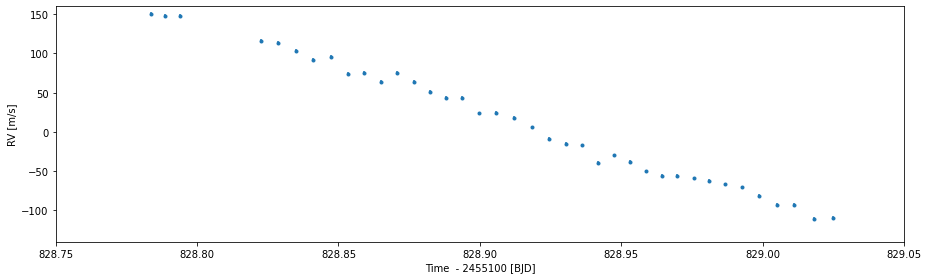

In [7]:
fig, ax = subplots()
ax.errorbar(rv_data['BJD'] - 2455100, rv_data['RVel'], rv_data['e_RVel'], fmt='.')
setp(ax, xlabel='Time  - 2455100 [BJD]', ylabel='RV [m/s]', xlim=(828.75, 829.05), ylim=(-140., 160.))
fig.tight_layout()

## 1.2 Search for a radial velocity signal

First, we use a Lomb-Scargle periodigram to search for a sinusoidial radial velocity signal from the RV measurements. This is simple to do with `astropy.timeseries.LombScargle` class that is initialised with the mid-measurement times and the RV observations.

In [8]:
ls = LombScargle(rv_data['BJD'], rv_data['RVel'])

Next, we use the `LombScargle.autopower` to calculate the periodogram. We restrict the search to $0.5 < P < 5$ days.

In [9]:
frequency, power = ls.autopower(minimum_frequency=1/(5*u.d), maximum_frequency=2/u.d)
period = 1/frequency

In [10]:
best_period = period[argmax(power)]
best_period

<Quantity 1.09144998 d>

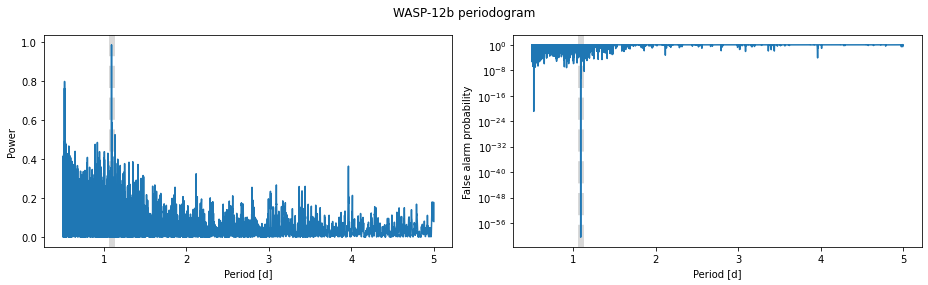

In [11]:
fig, axs = subplots(1, 2, figsize=(13,4))
axs[0].plot(period, power)
axs[1].semilogy(period, ls.false_alarm_probability(power))
[ax.axvline(best_period.value, c='k', ls='--', zorder=-1, lw=6, alpha=0.15) for ax in axs]
setp(axs, xlabel='Period [d]')
setp(axs[0], ylabel='Power')
setp(axs[1], ylabel='False alarm probability')
fig.suptitle('WASP-12b periodogram')
fig.tight_layout()

Let's see what happens when we plot the RV values folded over the best period.

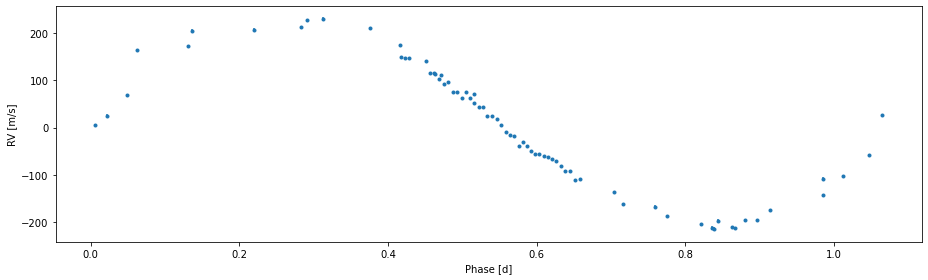

In [12]:
fig, ax = subplots()
ax.errorbar(rv_data['BJD'] % best_period.value, rv_data['RVel'], rv_data['e_RVel'], fmt='.')
setp(ax, xlabel='Phase [d]', ylabel='RV [m/s]')
fig.tight_layout()

## 1.3 Radial velocity modelling

Now when we know the RV data contains a suspicious signal, we can model it to study what sort of an object is causing it. The two most important parameters we're interested are the orbital period and radial velocity semiamplitude (K). The RV semiamplitude will give us the lower limit of the object's mass ($m\sin i$) which will then tell us whether we're dealing with a planet or something else.

### Initialise the model

In [13]:
lpf = RVLPF('WASP-12b', 1, rv_data['BJD'], rv_data['RVel'], rv_data['e_RVel'])

In [14]:
lpf.ps

[  0 |G| tc_1           N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   1 |G| p_1            N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf],
   2 |G| secw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   3 |G| sesw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   4 |G| rv_shift_0     N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   5 |G| rv_err_0       U(a = 0.0, b = 1.0)                      [    -inf ..      inf],
   6 |G| rv_k_1         U(a = 0.0, b = 1.0)                      [    0.00 ..      inf],
   7 |G| rv_slope       N(μ = 0.0, σ = 1.0)                      [    -inf ..      inf]]

### Set the parameter priors

Bayesian inference requires a prior probability distribution for each of our model parameters. These "priors" can be based on previous studies, theoretical expectations, or more generally in our beliefs on what values the parameters can take.

In this case we use two priors: a normal prior (NP) and a uniform prior (UP). The normal prior models our prior belief using a normal distribution with a known mean and standard deviation, while the uniform prior says that the paramer can take any value between a minimum and maximum boundary.

In [15]:
lpf.set_prior('tc_1', 'NP', 0.0, 1e-5)  # Normal prior (mean, sigma)
lpf.set_prior('p_1', 'NP', 1.09, 0.1)
lpf.set_prior('rv_shift_0', 'NP', 0.0, 10)
lpf.set_prior('rv_err_0', 'UP', 0.0, 30.0) # Uniform prior (min, max)
lpf.set_prior('rv_k_1', 'UP', 0.0, 300)

In [16]:
lpf.ps

[  0 |G| tc_1           N(μ = 0.0, σ = 1e-05)                    [    -inf ..      inf],
   1 |G| p_1            N(μ = 1.09, σ = 0.1)                     [    0.00 ..      inf],
   2 |G| secw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   3 |G| sesw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   4 |G| rv_shift_0     N(μ = 0.0, σ = 10.0)                     [    -inf ..      inf],
   5 |G| rv_err_0       U(a = 0.0, b = 30.0)                     [    -inf ..      inf],
   6 |G| rv_k_1         U(a = 0.0, b = 300)                      [    0.00 ..      inf],
   7 |G| rv_slope       N(μ = 0.0, σ = 1.0)                      [    -inf ..      inf]]

### Fit the model to the data

Global optimisation:   0%|          | 0/2000 [00:00<?, ?it/s]

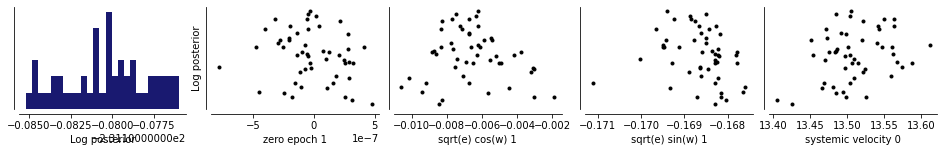

In [17]:
lpf.optimize_global(2000)

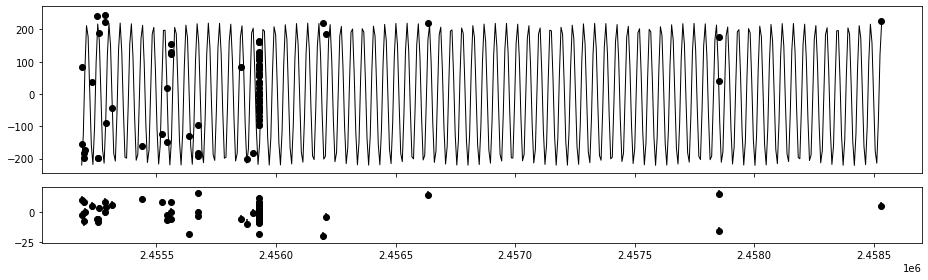

In [18]:
lpf.plot_rv_vs_time();

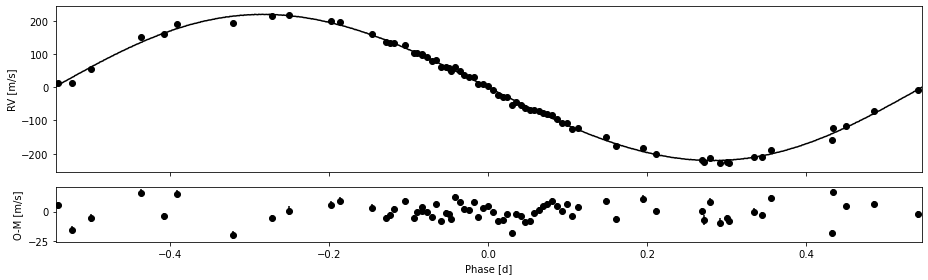

In [19]:
lpf.plot_rv_vs_phase(0);

### Estimate the parameter posterior distributions using MCMC

We estimate the [posterior probability distributions](https://en.wikipedia.org/wiki/Posterior_probability) of our model parameters using [Markov Chain Monte Carlo sampling](https://twiecki.io/blog/2015/11/10/mcmc-sampling). The sampling can be done using the `RVLPF.sample_mcmc` method after a global optimisation run has been finished. The `sample_mcmc` method uses the [*emcee*](https://emcee.readthedocs.io/en/stable) sampler under the hood.

We give `RVLPF.sample_mcmc` the number of MCMC steps to take (`niter`), a thinning factor (`thin`), and a number of repeats (`repeats`). This makes the sampler run first one round of `niter` steps, restarts the sampler from the last step of the previous run, and run again `niter` steps. This is the same as running the sampler for `2 x niter` and keeping only the second half of the steps. The first half is treated as a [warm-up period](https://stats.stackexchange.com/questions/88819/mcmc-methods-burning-samples) for the sampler and discarded. In general, the sampler is run `repeats x niter` steps in total, and only the last `niter` steps are retained.

The thinning factor tells the sampler to store only every $n$th step. In our case, we're storing only every 10th step. Thinning is a way to try to store only statistically independent samples, but is [not really necessary](https://besjournals.onlinelibrary.wiley.com/doi/pdf/10.1111/j.2041-210X.2011.00131.x). However, we'll do it to keep the number of samples low (there's no point in storing a large number of dependent samples either).

In [20]:
lpf.sample_mcmc(niter=2000, thin=10, repeats=2)

MCMC sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Run 1/2:   0%|          | 0/2000 [00:00<?, ?it/s]

Run 2/2:   0%|          | 0/2000 [00:00<?, ?it/s]

The *emcee* sampler uses an ensemble of MCMC chains to sample the posterior. This means that we have many chains running in parallel. We can plot the traces of each chain to see how the chain population behaves in time.

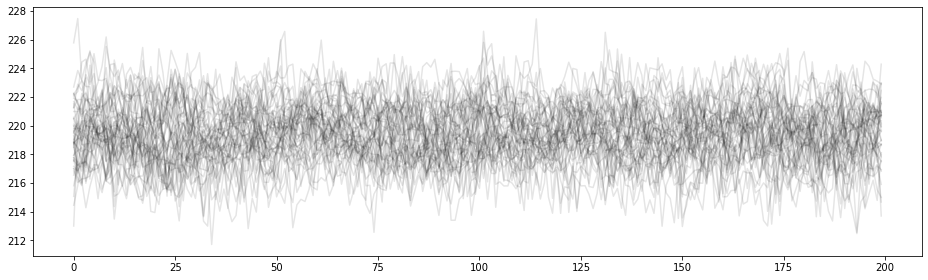

In [21]:
lpf.plot_mcmc_chains(6);

### Plot the model posterior

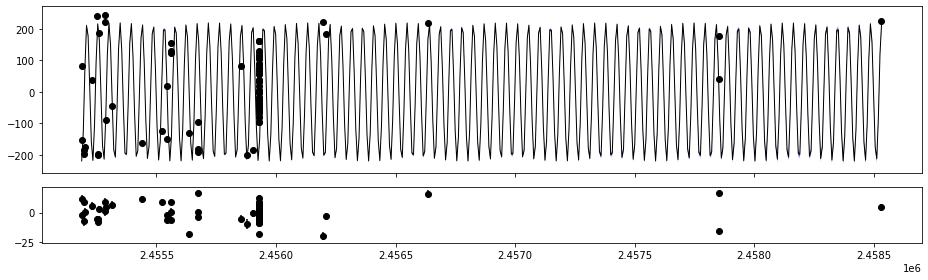

In [22]:
lpf.plot_rv_vs_time('mcmc');

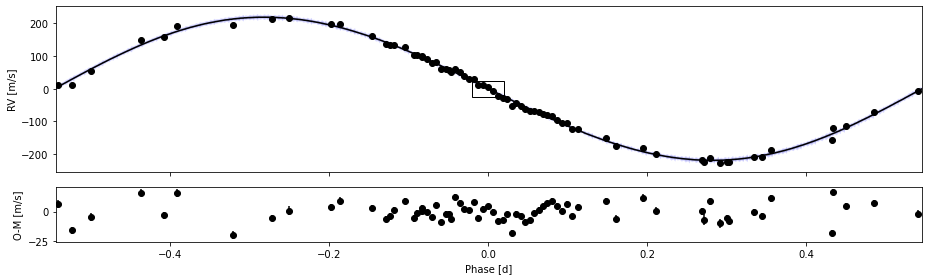

In [23]:
fig = lpf.plot_rv_vs_phase(0, 'mcmc')
fig.axes[0].add_patch(Rectangle((-.02, -25), 0.04, 50, fill=False));

When we zoom a little bit, we can see that we're now actually plotting the probability density of the model. The black line corresponds to the median of the model posterior, and the two shades to the 68% and 95% central posterior limits.

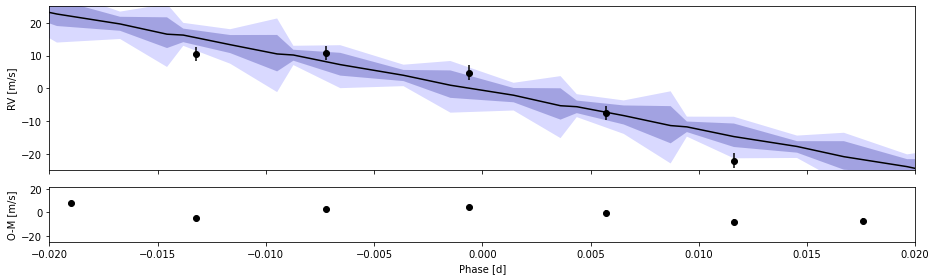

In [24]:
fig = lpf.plot_rv_vs_phase(0, 'mcmc')
setp(fig.axes[0], xlim=(-0.02, 0.02), ylim=(-25,25));

### Plot the parameter posteriors

In [25]:
df = lpf.posterior_samples()
df

,tc_1,p_1,secw_1,sesw_1,rv_shift_0,rv_err_0,rv_k_1,rv_slope
0,9.800184e-06,1.091423,-0.106627,-0.124994,13.685713,7.439028,220.468864,-0.003657
1,1.221426e-05,1.091423,-0.118526,-0.087663,12.091765,7.831972,219.143061,-0.002417
2,5.693228e-06,1.091423,-0.051856,-0.125238,12.915428,7.345594,218.962187,-0.001187
3,5.273080e-06,1.091423,-0.068621,-0.121436,12.763565,7.474194,219.476067,-0.001597
4,1.352625e-05,1.091423,-0.083206,-0.100102,12.396987,8.065079,218.878854,-0.003003
...,...,...,...,...,...,...,...,...
9995,2.411606e-07,1.091423,0.007319,-0.158937,15.309662,6.691600,219.024725,0.001380
9996,5.967425e-06,1.091423,-0.001002,-0.144783,14.171668,7.188814,218.089680,0.000243
9997,1.153820e-05,1.091423,-0.075095,-0.149797,13.721684,6.710748,218.452767,-0.000845
9998,4.729920e-06,1.091423,-0.010058,-0.146764,14.772558,6.897947,219.535230,0.000683


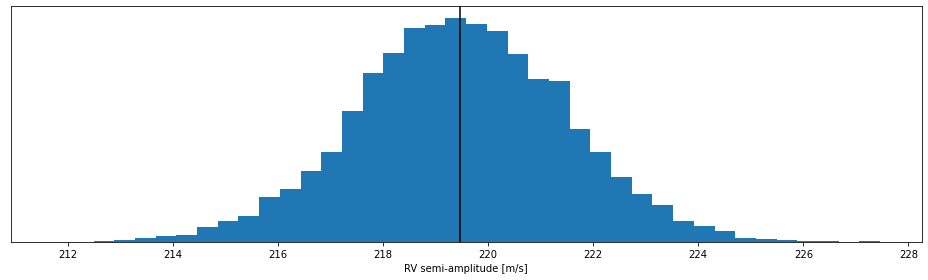

In [26]:
fig, ax = subplots()
ax.hist(df.rv_k_1, bins=40)
ax.axvline(median(df.rv_k_1), c='k')
setp(ax, xlabel='RV semi-amplitude [m/s]', yticks=[])
fig.tight_layout()

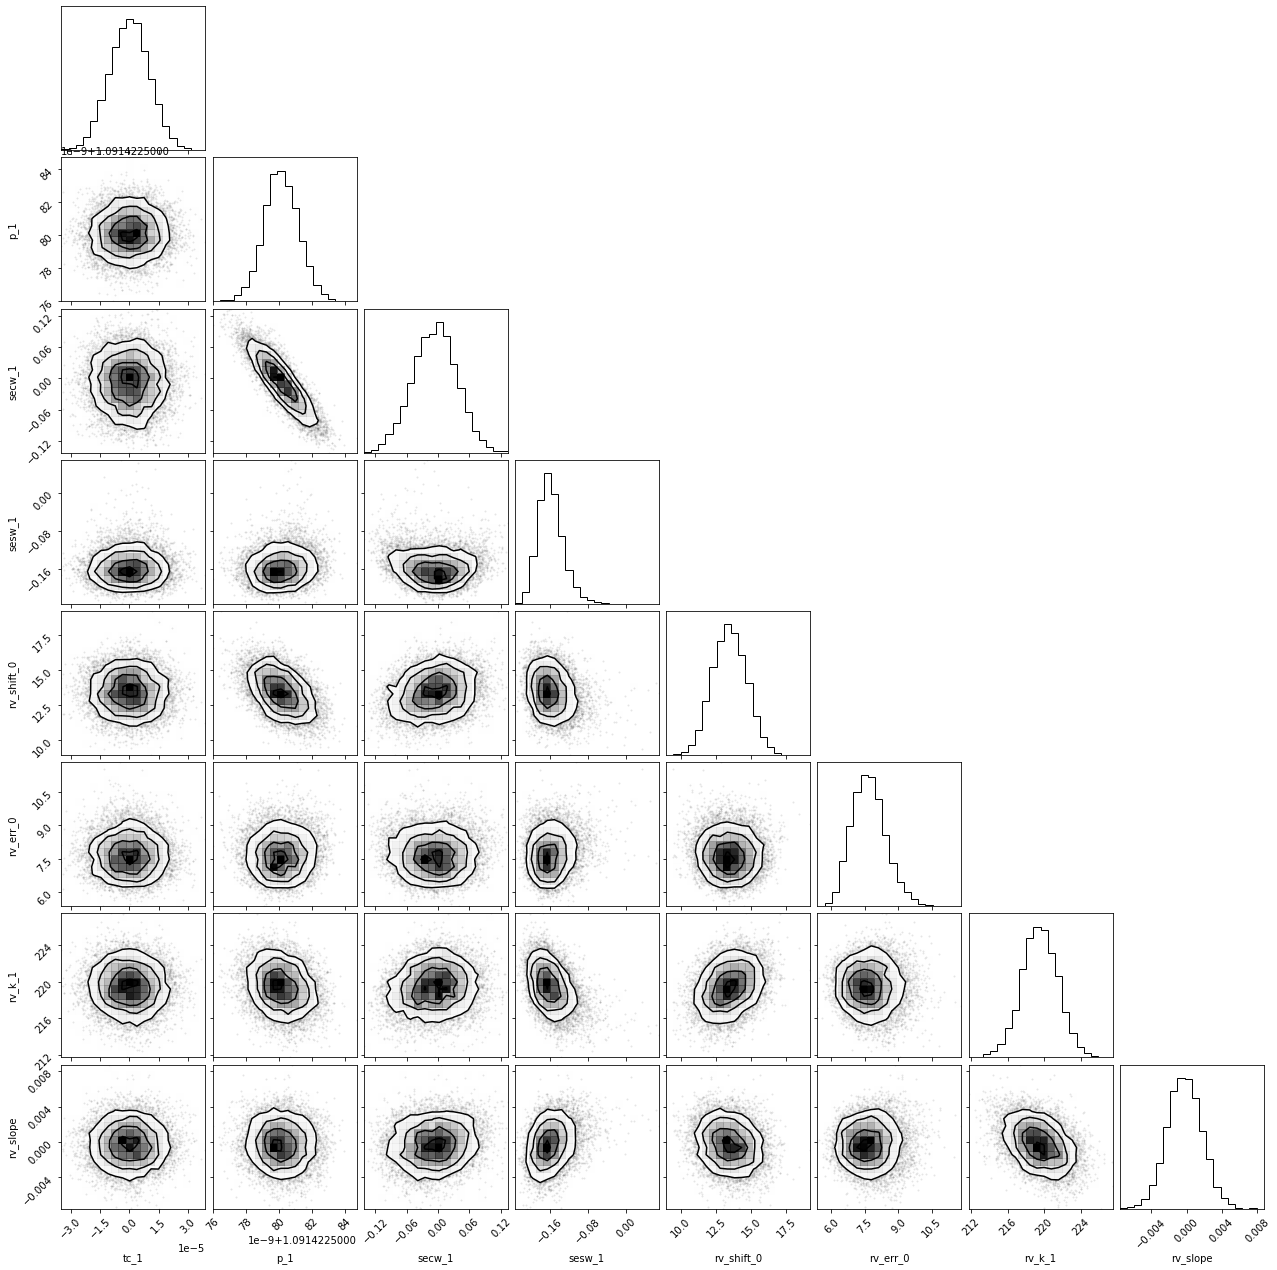

In [27]:
corner(df, labels=df.columns);

In [28]:
import numpy as np
mstar = 1.4 * 2.0E30 # Mass of WASP-12 (kg)
mjupi = 1.9E27 # Jupiter's mass (kg)
guni = 6.7E-11 # Gravitational constant (m3 kg-1 s-2)
day = 86400. # Day in seconds
rtd = 180./np.pi # degree/rad
third = 1./3.
fac = ((mstar*mstar / (2.*np.pi*guni)) ** third) / mjupi

# Eccentricity and argument of periastron
ecc = (df.secw_1)**2. + (df.sesw_1)**2.
omega = np.arctan2(df.sesw_1, df.secw_1) * rtd # (degree)
mecc = np.median(ecc)
sigecc = np.std(ecc)
mome = np.median(omega)
sigome = np.std(omega)
print('Orbital eccentricity = ', round(mecc,3), '+/-', round(sigecc,3))
print('Argument of periastron = ', round(mome), '+/-', round(sigome), ' [degree]')

# Minimum planet mass (kg)
mpsi = fac * df.rv_k_1 * np.sqrt(1.-ecc*ecc) * (df.p_1*day)**third # Mp*sin(i) (Jupiter masses)
med_mpsi = np.median(mpsi)
sig_mpsi = np.std(mpsi)

# Direct stimate from MCMC
print('Planet mass = ', round(med_mpsi,2), '+/-', round(sig_mpsi,2), ' [Jupiter mass]')

# Adding star mass uncertainty
from math import sqrt
unc_mstar = (((1.5/1.4) ** (2./3.)) - 1.) * med_mpsi # Scatter due to star mass uncertainty
sig_tot = sqrt(unc_mstar * unc_mstar + sig_mpsi * sig_mpsi) # Total scatter
print('Including star mass uncentainty:', round(med_mpsi,2), '+/-', round(sig_tot,2), ' [Jupiter mass]')

# Earth orbiting WASP-12
mearth = 5.97E24 # Eart's mass (kg), neglected when appropriate
pearth = (365. * day) # Orbital period (s)
n = 2. * np.pi / pearth # Mean motion (rad/s)
dist = ((guni * mstar) / (n * n)) ** third # Orbital distance (m)
rstar = dist * mearth / (mstar) # Orbital radius of star respect to common baricenter (m)
vstar = n * rstar # Orbital velocity of star (m/s)
print('Maximum RV semi-amplitude = ', round(vstar,3), ' [m/s]')

# Check with formula on top
kmax = ((2. * np.pi * guni / pearth) ** third) * mearth / (mstar ** (2./3.))
print('RV semi-amplitude cross-check = ', round(kmax,3), ' [m/s]')


Orbital eccentricity =  0.028 +/- 0.008
Argument of periastron =  -92 +/- 18  [degree]
Planet mass =  1.39 +/- 0.01  [Jupiter mass]
Including star mass uncentainty: 1.39 +/- 0.07  [Jupiter mass]
Maximum RV semi-amplitude =  0.071  [m/s]
RV semi-amplitude cross-check =  0.071  [m/s]


### <span style="color:darkblue">Questions and exercises</span>

1. What is the minimum mass ($m\sin i$) of WASP-12b? You can derive this from the RV semi-amplitude (K), orbital period (p), and the host star mass.

- The calculations are in the cell above. Using the same value of the star mass as in Yee+2019 (1.4 +/- 0.1 solar masses), and assuming the planet's mass is negligible in comparison, we obtain 1.39 +/- 0.01 Jupiter masses. While in rigor this is the minimum mass, transits of WASP-12b have been detected, meaning the inclination of the line of sight is close to 90 degrees. Therefore, the minimum mass and real mass should be very similar.

    The mass has been computed using the posteriors from the MCMC to avoid assuming a value for the orbital eccentricity (histogram in the cell below). However, it does not include the effect of the uncertainty in WASP-12’s mass, which is considerable. Adding this effect gives 1.39 +/- 0.07 $M_J$; that is, the uncertainty of the star mass dominates the error. This result is compatible with the value reported in Yee+2019 (1.47 +/- 0.07 $M_J$).

2. What would be the RV semi-amplitude of an Earth-mass planet orbiting WASP-12 with an orbital period of 365 days?

- Given the large orbital distance (over 1 au) and small mass, the maximum radial velocity (i.e., assuming i=90 degree) induced by such planet would be on the order of 7 cm/s, and thus not detectable with current technology (calculations in cell above).

3. We parameterise the model using ($\sqrt{e}\sin\omega$, $\sqrt{e}\cos\omega$) instead of ($e$, $\omega$). This parameterisation is more efficient to sample with an MCMC sampler, but means we need to take some extra steps to get the eccentricity and argument of periastron samples. Write below the equations you need to use to map the sampling parameters to $e$ and $\omega$?

    $\begin{array}{l}
e = {\left( {\sqrt e \cos \omega } \right)^2} + {\left( {\sqrt e \sin \omega } \right)^2}\\
\omega  = {\rm{atan2}}\left( {\sqrt e \sin \omega ,\sqrt e \cos \omega } \right)
\end{array}$


4. Derive $e$ and $\omega$ from the MCMC samples and plot their histograms.

- The estimates of eccentricity and argument of periastron are 0.028 +/- 0.008 and -90 +/- 20 degree, respectively (calculations above and histograms below).

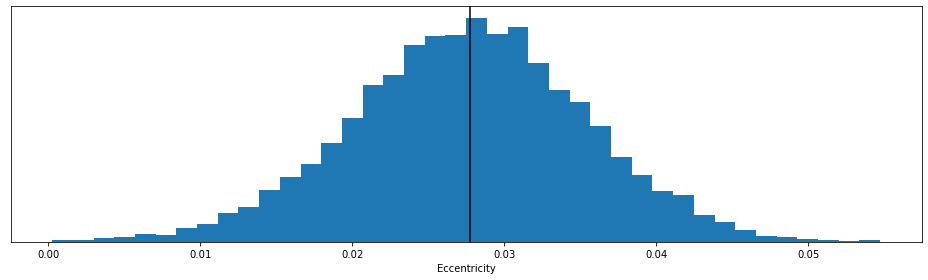

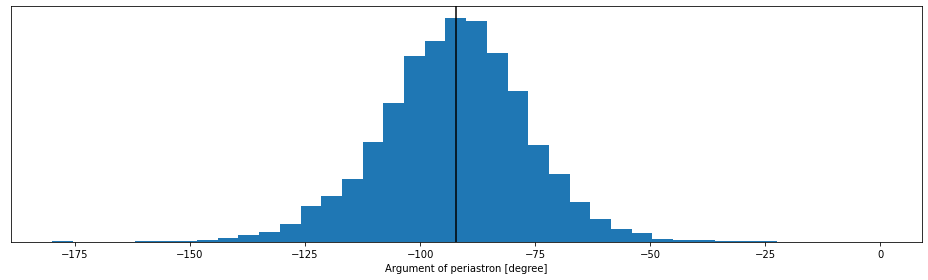

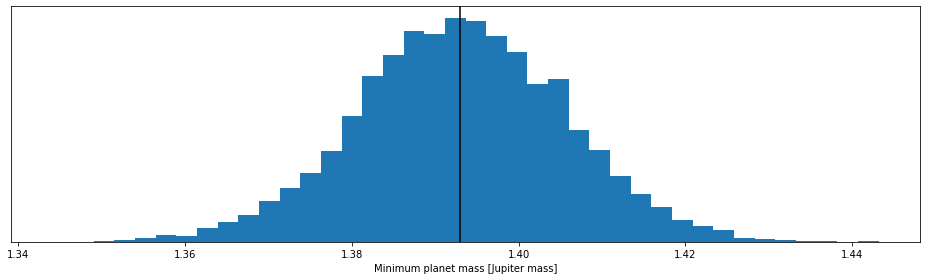

In [32]:
# Eccentricity plot
fig, ax = subplots()
ax.hist(ecc, bins=40)
ax.axvline(median(ecc), c='k')
setp(ax, xlabel='Eccentricity', yticks=[])
fig.tight_layout()

# Argument of periastron plot
fig, ax = subplots()
ax.hist(omega, bins=40, range=(-180.,0))
ax.axvline(median(omega), c='k')
setp(ax, xlabel='Argument of periastron [degree]', yticks=[])
fig.tight_layout()

# Minimum mass plot
fig, ax = subplots()
ax.hist(mpsi, bins=40)
ax.axvline(med_mpsi, c='k')
setp(ax, xlabel='Minimum planet mass [Jupiter mass]', yticks=[])
fig.tight_layout()

---

<center>&copy;2022 Hannu Parviainen</center>